In [220]:
import sys
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
from copy import copy
from qca import QCA
from figures import names, colors
from core1d import rule_hamiltonian
from states import make_state
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import multi_dot
from scipy.linalg import expm
from matrix import op_at, dagger
from measures import expectation
from time import time
%matplotlib inline

In [2]:
import matrix
import qca
import states
import core1d
from importlib import reload
reload(core1d)
reload(matrix)
reload(qca)
reload(states)


from qca import QCA, QCA_from_file, main_from_params_list
from states import make_state
from measures import get_rhoj, get_expectation
from matrix import ops

# 2-qubit ferromagnetic state at 45 degrees
psi = make_state(2, "ot45")

# verify
rhoj = get_rhoj(psi)
X = get_expectation(rhoj, ops["X"])
Y = get_expectation(rhoj, ops["Y"])
Z = get_expectation(rhoj, ops["Z"])
print(X)
print(Y)
print(Z)
np.arccos(Z/np.sqrt(X*X+Z*Z)) * 180/np.pi

[0.70710678 0.70710678]
[0. 0.]
[0.70710678 0.70710678]


array([45., 45.])

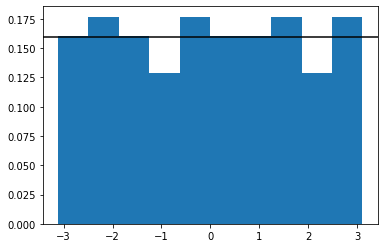

In [3]:
# Haar random matrix
from matrix import haar, isU, ops
U = haar(100) # 100-dimensional array
eigs = np.linalg.eigvals(U)

# haar random matrix is unitary and has eigenvalues exp(i theta) 
# with theta unifromly distributed 
phs = np.angle(eigs)
plt.hist(phs, density="True")
plt.axhline(1/(2*np.pi), c="k")

In [85]:
%%time
der = r"/home/lhillber/documents/research/cellular_automata/qca/data/"
from qca import QCA, QCA_from_file, main_from_params_list

run = False

Rs = [1, 6, 9, 14, 13]
Ls = [6,8,10,12,14,16,18]
ICs = ["ot45"]

params_template = dict(
              T=100.0,
              L=20,
              dt=1.0,
              r=1,
              V="A",
              BC="0",
              E=0.0,
              N=100,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)

params_list = []
Qs = np.zeros((len(ICs), len(Rs), len(Ls)), dtype="object")
for ICi, IC in enumerate(ICs):
    for Ri, R in enumerate(Rs):
        for Li, L in enumerate(Ls):
            params = copy(params_template)
            params["R"] = R
            params["IC"] = IC
            params["L"] = L
            params_list.append(params)
            if not run:
                Q = QCA(params, der=der)
                Qs[ICi, Ri, Li] = Q
                
print(len(params_list))           
if run:
    main_from_params_list(params_list,
                          tasks=["rhoj", "rhojk", "ebipart", "rho3", "rho4", "rho5"], 
                          der=der, 
                          nprocs=-1,
                          recalc=False)

35
CPU times: user 52.6 ms, sys: 10.1 ms, total: 62.7 ms
Wall time: 61.7 ms


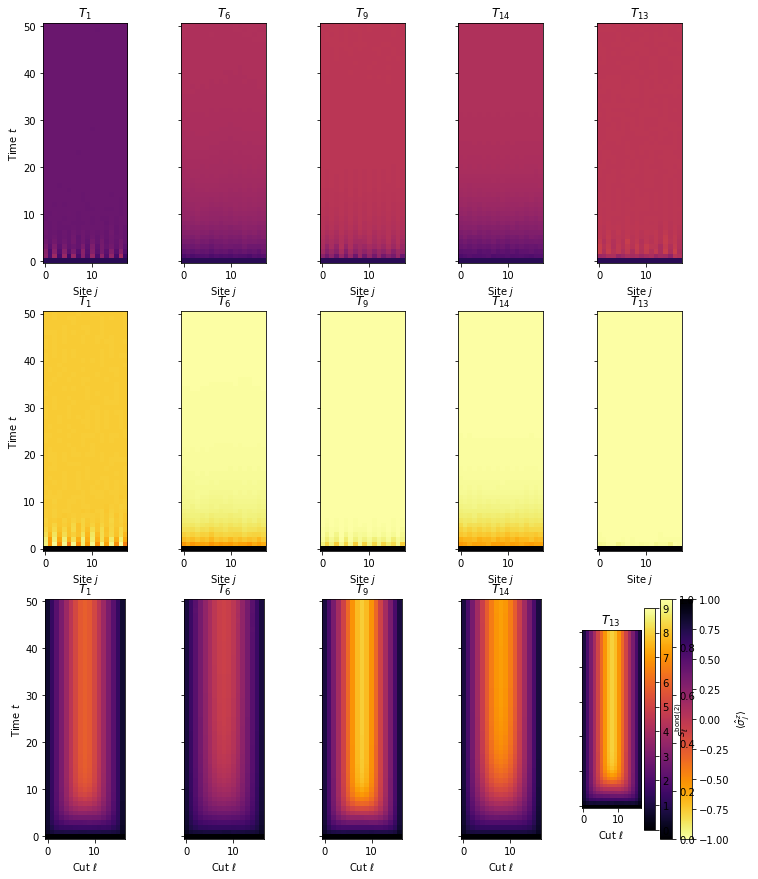

In [86]:
measures = ["exp_Z", "s", "sbipart_2"]
fig, axs = plt.subplots(len(measures), len(Rs), figsize=(12, 15))
for measi, meas in enumerate(measures):
    for ICi, IC in enumerate(ICs):
        for Ri, R in enumerate(Rs):
            if Ri == len(Rs) - 1:
                cbar = True
            else:
                cbar = False
            Q = Qs[ICi, Ri, -1]
            ax = axs[measi, Ri]
            if meas.split("_")[0] == "s":
                cmap = "inferno"
                vmin=0
                vmax=1
            elif meas.split("_")[0] == "exp":
                cmap = "inferno_r"
                vmin=-1
                vmax=1
            elif meas.split("_")[0] == "sbipart":
                cmap = "inferno"
                vmin=0
                vmax=Q.L//2
            Q.plot(meas, ax=ax, tmax=50, cbar=cbar, cmap=cmap, vmin=vmin, vmax=vmax)
            if Ri != 0:
                ax.set_ylabel("")
                ax.set_yticklabels([])
            if ICi == 0:
                ax.set_title(r"$T_{%s}$"%R)


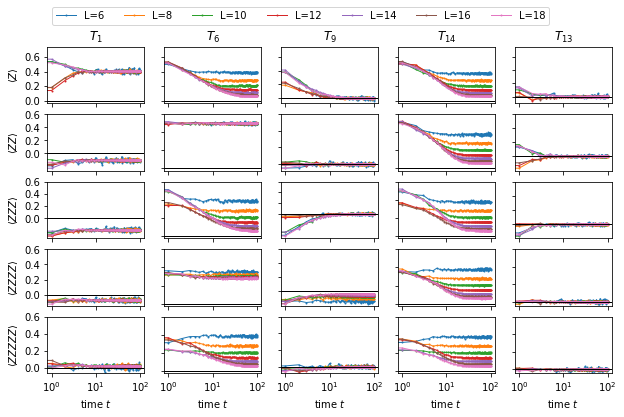

In [90]:
op = "Z"
measures = [f"expn_{op*i}" for i in range(1, 6)]
fig, axs = plt.subplots(len(measures), len(Rs), figsize=(3.375*3, 6))
for measi, meas in enumerate(measures):
    for ICi, IC in enumerate(ICs):
        for Ri, R in enumerate(Rs):
            for Li, L in enumerate(Ls):
                Q = Qs[ICi, Ri, Li]
                ax = axs[measi, Ri]
                if meas == "s":
                    cmap = "inferno"
                    vmin=None
                    vmax=1
                else:
                    cmap = "inferno_r"
                    vmin=None
                    vmax=None
                m = Q.get_measure(meas)
                ax.plot(m, marker=".", label=f"L={Q.L}", ms=2, lw=1)
                ax.set_xscale("log")
                ax.set_yticks([0,0.2, 0.4, 0.6])
                if Ri != 0:
                    ax.set_ylabel("")
                    ax.set_yticklabels([])
                else:
                    ax.set_ylabel(r"$\langle %s \rangle$"%meas.split("_")[1])
                if measi != len(measures)-1:
                    ax.set_xlabel("")
                    ax.set_xticklabels([])
                else:
                    ax.set_xlabel("time $t$")
                if measi == 0:
                    ax.set_title(r"$T_{%s}$"%R)
                if measi == 0 and Ri == 0:
                    ax.legend(loc="lower left", 
                              bbox_to_anchor=(0,1.3),
                              ncol=len(Ls))
                ax.minorticks_off()
                ax.axhline(0, c="k", lw=1)

plt.savefig("figures/pauliZ_thermalization_100trial.pdf")

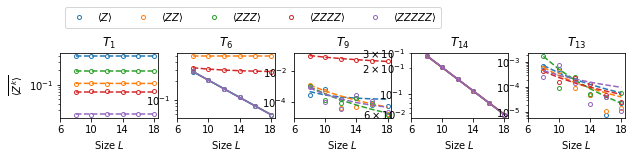

In [191]:
op = "Z"
lss = ["-", "--"]
fitfs = ["exp", "pow"]
measures = [f"expn_{op*i}" for i in range(1, 6)]
fig, axs = plt.subplots(1, len(Rs), figsize=(3.375*3, 6/5))
for Ri, R in enumerate(Rs[:]):
    ax = axs[Ri]
    for measi, meas in enumerate(measures):
        color = f"C{measi}"
        for ICi, IC in enumerate(ICs):
            ms = []
            for L in Ls[1:]:
                Li = Ls.index(L)
                Q = Qs[ICi, Ri, Li]
                if meas == "s":
                    cmap = "inferno"
                    vmin=None
                    vmax=1
                else:
                    cmap = "inferno_r"
                    vmin=None
                    vmax=None
                m = Q.get_measure(meas)
                ms.append(m[50:].mean())
            x = np.array(Ls[1:], dtype=float)
            y = np.array(np.abs(ms))
            ax.plot(x, y, marker="o", mec=color, mfc="none", ms=4, ls="none", label=r"$\langle %s \rangle$"%meas.split("_")[1])
            ind, fs, popts, pcovs, rms = fit(x, y)
            f = fs[ind](x)
            if np.all(f>0):
                ax.plot(x, f, color=color, ls=lss[ind])
            
            if Ri != 0:
                ax.set_ylabel("")
                ax.set_yticklabels([])
            else:
                ax.set_ylabel(r"$\overline{\langle Z^k \rangle}$")

            ax.set_xticks(Ls[::2])
            ax.set_xlabel("Size $L$")
            if measi == 0:
                ax.set_title(r"$T_{%s}$"%R)
            if Ri == 0 and Ri == 0:
                ax.legend(loc="lower left", 
                          bbox_to_anchor=(0,1.3),
                          ncol=len(Ls))
            ax.minorticks_off()
            #ax.axhline(0, c="k", lw=0.5)
            ax.set_yscale("log")


# plt.savefig("figures/finite-size_pauliZ_thermalization_100trial.pdf", bbox_inches="tight")

In [188]:
from scipy.optimize import curve_fit
def exp_func(x, c, A, B):
    return A*np.exp(-x / c) + B

def pow_func(x, c, A, B):
    return A*x**(-c) + B

def fit(x, y, exp_p0=(-1.0, 0.1, 0.0), pow_p0=(-1.0, 0.1, 0.0)):
    exp_p0 = (1.0, 1, y[-1])
    try:
        exp_popt, exp_pcov = curve_fit(exp_func, x, y, p0=exp_p0, bounds=(0, np.inf))
    except:
        exp_popt = [-1, -1, -1]
        exp_pcov = [-1, -1, -1]
    def expf(x):
        return exp_func(x, *exp_popt)
    exp_rms = np.sqrt(np.sum((y - expf(x))**2))
    
    pow_p0 = (0.0, 1, y[-1])
    try:
        pow_popt, pow_pcov = curve_fit(pow_func, x, y, p0=pow_p0, bounds=(0, np.inf))
    except:
        pow_popt = [-1, -1, -1]
        pow_pcov = [-1, -1, -1]
    def powf(x):
        return pow_func(x, *pow_popt)
    
    pow_rms = np.sqrt(np.sum((y - powf(x))**2)) 
    fs = [expf, powf]
    popts = [exp_popt, pow_popt]
    pcovs  = [exp_pcov, pow_pcov]
    rms = [exp_rms, pow_rms]
    
    if np.abs(rms[1] - rms[0]) > 1e-3:
        ind = np.argmin(rms)
    else:
        ind = 1
    
    
    return ind, fs, popts, pcovs, rms
    
    

(5, 3)
(5, 3)
(5, 3)
(5, 3)
(5, 3)


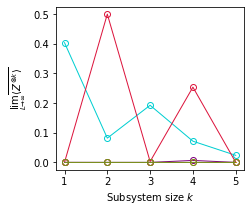

In [232]:
op = "Z"
lss = ["-", "--"]
fitfs = ["exp", "pow"]
measures = [f"expn_{op*i}" for i in range(1, 6)]
fig, ax = plt.subplots(1, 1, figsize=(3.375, 3))
for Ri, R in enumerate(Rs[:]):
    popts = []
    for measi, meas in enumerate(measures):
        color = f"C{measi}"
        for ICi, IC in enumerate(ICs):
            ms = []
            for L in Ls[1:]:
                Li = Ls.index(L)
                Q = Qs[ICi, Ri, Li]
                if meas == "s":
                    cmap = "inferno"
                    vmin=None
                    vmax=1
                else:
                    cmap = "inferno_r"
                    vmin=None
                    vmax=None
                m = Q.get_measure(meas)
                ms.append(m[50:].mean())
            x = np.array(Ls[1:], dtype=float)
            y = np.array(np.abs(ms))
            ind, fs, poptsf, pcovs, rms = fit(x, y)
            popts.append(poptsf[ind])
    popts = np.array(popts)
    print(popts.shape)
    ax.plot(np.arange(1, len(measures)+1), popts[:, -1], lw=1, marker="o", color=colors[R], mfc="none", mec=colors[R])
    ax.set_ylabel(r"$\lim_{L\to \infty} \overline {\langle Z^{\otimes k} \rangle}$")
    ax.set_xlabel("Subsystem size $k$")
    #ax.set_yscale("log")
# plt.savefig("figures/finite-size_pauliZ_thermalization_100trial.pdf", bbox_inches="tight")

In [222]:
colors[9] = "purple"